# Prophet Time Series Forecasting for Daily Acquisition Data

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from datetime import datetime, timedelta
import requests
from io import BytesIO

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Configuration
# Calculate days until end of 2025
from datetime import datetime, timedelta

def calculate_days_until_end_of_year(target_year=2025):
    """Calculate number of days from today until end of target year"""
    today = datetime.now()
    end_of_year = datetime(target_year, 12, 31)
    
    if today.year > target_year:
        return 0  # Target year has passed
    
    days_remaining = (end_of_year - today).days
    return max(0, days_remaining)

# LSTM Configuration
LOOK_BACK = 60  # Number of previous days to use for prediction
VALIDATION_SIZE = 0.2  # 20% of data for validation
TEST_SIZE = 0.2  # 20% of data for testing

# Calculate forecast days until end of 2025
FORECAST_DAYS = calculate_days_until_end_of_year(2025)

# LSTM model parameters
LSTM_PARAMS = {
    'units': 50,
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'epochs': 100,
    'batch_size': 32,
    'patience': 20
}

print(f"LSTM Configuration:")
print(f"- Look back period: {LOOK_BACK} days")
print(f"- Validation size: {VALIDATION_SIZE*100}%")
print(f"- Test size: {TEST_SIZE*100}%")
print(f"- Forecast until: December 31, 2025")
print(f"- Forecast days: {FORECAST_DAYS}")
print(f"- LSTM params: {LSTM_PARAMS}")

if FORECAST_DAYS == 0:
    print("⚠️  Warning: 2025 has already passed. Forecast will be empty.")
elif FORECAST_DAYS < 30:
    print(f"⚠️  Warning: Only {FORECAST_DAYS} days remaining in 2025.")

# Data

In [ ]:
# Load and preprocess the dataset
def load_data():
    """Load data from Google Sheets with error handling"""
    try:
        # URL to Google Sheets (Excel format)
        url = "https://docs.google.com/spreadsheets/d/12EuA3FX_e3Xh1xRxn13qX2mOKzAkZgE7/export?format=xlsx"
        
        # Download Excel file to memory
        response = requests.get(url, timeout=30)
        response.raise_for_status()  # Raise an exception for bad status codes
        file_data = BytesIO(response.content)
        
        # Read Excel to DataFrame
        df = pd.read_excel(file_data, sheet_name=2, engine='openpyxl')
        
        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Fallback: create sample data for testing
        print("Creating sample data for testing...")
        dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
        values = np.random.randint(50, 200, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 30
        df = pd.DataFrame({'tanggal': dates, 'jumlah': values})
        return df

# Load the data
df = load_data()
print("\nFirst 5 rows:")
display(df.head())
print("\nLast 5 rows:")
display(df.tail())

,tanggal,jumlah
0,2024-02-01 00:00:00,1589
1,2024-03-01 00:00:00,599
2,2024-04-01 00:00:00,1089
3,2024-05-01 00:00:00,347
4,2024-06-01 00:00:00,121


In [ ]:
# Data exploration and preprocessing
def preprocess_data(df):
    """Preprocess the data for LSTM training"""
    # Convert tanggal to datetime
    df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
    
    # Handle missing values in jumlah column
    df['jumlah'] = pd.to_numeric(df['jumlah'], errors='coerce')
    
    # Remove rows with missing values
    df = df.dropna()
    
    # Sort by date
    df = df.sort_values('tanggal').reset_index(drop=True)
    
    # Create additional features
    df['year'] = df['tanggal'].dt.year
    df['month'] = df['tanggal'].dt.month
    df['day'] = df['tanggal'].dt.day
    df['dayofweek'] = df['tanggal'].dt.dayofweek
    df['dayofyear'] = df['tanggal'].dt.dayofyear
    
    return df

# Preprocess the data
df = preprocess_data(df)

print("Data Info:")
print(df.info())
print("\nData Statistics:")
print(df.describe())
print(f"\nDate range: {df['tanggal'].min()} to {df['tanggal'].max()}")
print(f"Total days: {len(df)}")

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Visualize the data
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(df['tanggal'], df['jumlah'])
plt.title('Daily Acquisition Over Time')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.hist(df['jumlah'], bins=30, alpha=0.7)
plt.title('Distribution of Jumlah')
plt.xlabel('Jumlah')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
df.boxplot(column='jumlah', by='month', ax=plt.gca())
plt.title('Jumlah by Month')
plt.suptitle('')

plt.subplot(2, 2, 4)
df.boxplot(column='jumlah', by='dayofweek', ax=plt.gca())
plt.title('Jumlah by Day of Week')
plt.suptitle('')

plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tanggal  618 non-null    object
 1   jumlah   618 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


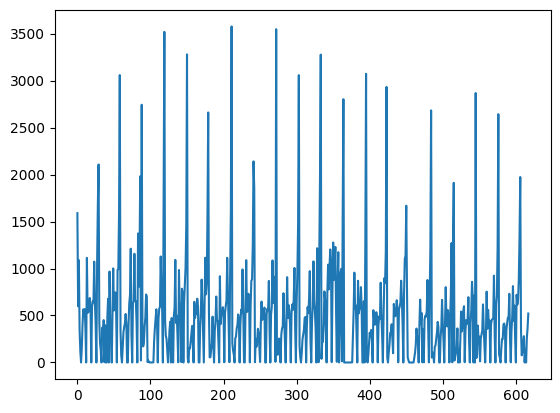

In [ ]:
# Prepare data for LSTM
def prepare_lstm_data(df, look_back=LOOK_BACK):
    """Prepare data for LSTM training"""
    # Extract the target variable
    data = df['jumlah'].values.astype('float32')
    
    # Handle any remaining missing values
    data = pd.Series(data).interpolate(method='linear').values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    
    return data_scaled, scaler, data

# Prepare the data
dataset, scaler, original_data = prepare_lstm_data(df, LOOK_BACK)

print(f"Dataset shape: {dataset.shape}")
print(f"Original data range: {original_data.min():.2f} - {original_data.max():.2f}")
print(f"Scaled data range: {dataset.min():.2f} - {dataset.max():.2f}")

# Visualize the normalized data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(original_data)
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
plt.plot(dataset)
plt.title('Normalized Data')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.tight_layout()
plt.show()

## Data Splitting and Sequence Creation

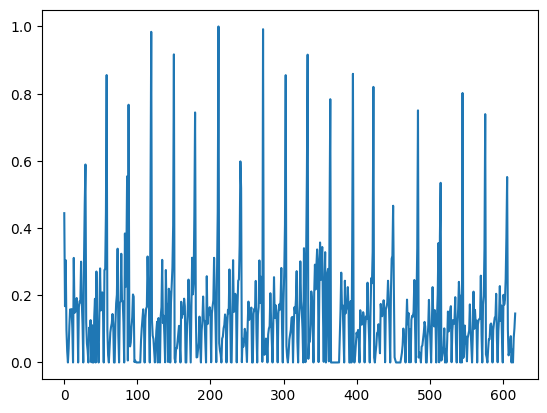

In [ ]:
# Split data into train, validation, and test sets
def split_data(dataset, test_size=TEST_SIZE, val_size=VALIDATION_SIZE):
    """Split data into train, validation, and test sets"""
    total_size = len(dataset)
    test_split = int(total_size * (1 - test_size))
    val_split = int(test_split * (1 - val_size))
    
    train_data = dataset[:val_split]
    val_data = dataset[val_split:test_split]
    test_data = dataset[test_split:]
    
    print(f"Data split:")
    print(f"- Training: {len(train_data)} samples ({len(train_data)/total_size*100:.1f}%)")
    print(f"- Validation: {len(val_data)} samples ({len(val_data)/total_size*100:.1f}%)")
    print(f"- Test: {len(test_data)} samples ({len(test_data)/total_size*100:.1f}%)")
    
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = split_data(dataset)

# Visualize the split
plt.figure(figsize=(15, 5))
plt.plot(range(len(train_data)), train_data, label='Training', color='blue')
plt.plot(range(len(train_data), len(train_data) + len(val_data)), val_data, label='Validation', color='orange')
plt.plot(range(len(train_data) + len(val_data), len(train_data) + len(val_data) + len(test_data)), 
         test_data, label='Test', color='red')
plt.title('Data Split Visualization')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

## Create Sequences for LSTM

In [ ]:
# Create sequences for LSTM
def create_sequences(data, look_back=LOOK_BACK):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for all datasets
X_train, y_train = create_sequences(train_data, LOOK_BACK)
X_val, y_val = create_sequences(val_data, LOOK_BACK)
X_test, y_test = create_sequences(test_data, LOOK_BACK)

print(f"Sequence shapes:")
print(f"- X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"- X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"- X_test: {X_test.shape}, y_test: {y_test.shape}")

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nReshaped for LSTM:")
print(f"- X_train: {X_train.shape}")
print(f"- X_val: {X_val.shape}")
print(f"- X_test: {X_test.shape}")

## LSTM Model Architecture

In [ ]:
# Build LSTM Model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    """Build and compile LSTM model"""
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units//2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Display model summary
print("LSTM Model Architecture:")
model.summary()

# Plot model architecture
from tensorflow.keras.utils import plot_model
try:
    plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
    print("Model architecture saved as 'lstm_model.png'")
except:
    print("Could not save model plot (graphviz not installed)")

## Model Training

In [ ]:
# Set up callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
]

# Train the model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training completed!")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"Best validation MAE: {min(history.history['val_mae']):.6f}")

## Model Evaluation

In [ ]:
# Make predictions on training, validation, and test sets
def make_predictions(model, X_data, scaler):
    """Make predictions and inverse transform them"""
    predictions = model.predict(X_data)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    return predictions

# Get predictions
train_pred = make_predictions(model, X_train, scaler)
val_pred = make_predictions(model, X_val, scaler)
test_pred = make_predictions(model, X_test, scaler)

# Inverse transform actual values
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    return rmse, mae, mape

# Calculate metrics for all datasets
train_rmse, train_mae, train_mape = calculate_metrics(y_train_actual, train_pred, "Training")
val_rmse, val_mae, val_mape = calculate_metrics(y_val_actual, val_pred, "Validation")
test_rmse, test_mae, test_mape = calculate_metrics(y_test_actual, test_pred, "Test")

## Visualization of Results

In [ ]:
# Create comprehensive visualization
def plot_predictions(actual, predicted, title, start_idx=0, end_idx=None):
    """Plot actual vs predicted values"""
    if end_idx is None:
        end_idx = len(actual)
    
    plt.figure(figsize=(15, 6))
    plt.plot(actual[start_idx:end_idx], label='Actual', alpha=0.7)
    plt.plot(predicted[start_idx:end_idx], label='Predicted', alpha=0.7)
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot predictions for each dataset
plot_predictions(y_train_actual, train_pred, "Training Set")
plot_predictions(y_val_actual, val_pred, "Validation Set")
plot_predictions(y_test_actual, test_pred, "Test Set")

# Create a combined plot
plt.figure(figsize=(20, 8))

# Calculate indices for plotting
train_end = len(y_train_actual)
val_end = train_end + len(y_val_actual)
test_end = val_end + len(y_test_actual)

# Plot all data
plt.plot(range(train_end), y_train_actual, label='Training Actual', color='blue', alpha=0.7)
plt.plot(range(train_end), train_pred, label='Training Predicted', color='blue', linestyle='--', alpha=0.7)

plt.plot(range(train_end, val_end), y_val_actual, label='Validation Actual', color='orange', alpha=0.7)
plt.plot(range(train_end, val_end), val_pred, label='Validation Predicted', color='orange', linestyle='--', alpha=0.7)

plt.plot(range(val_end, test_end), y_test_actual, label='Test Actual', color='red', alpha=0.7)
plt.plot(range(val_end, test_end), test_pred, label='Test Predicted', color='red', linestyle='--', alpha=0.7)

plt.title('Complete Model Performance - All Datasets')
plt.xlabel('Time Steps')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create scatter plots for accuracy assessment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set scatter
axes[0].scatter(y_train_actual, train_pred, alpha=0.6)
axes[0].plot([y_train_actual.min(), y_train_actual.max()], [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Training Set - Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Validation set scatter
axes[1].scatter(y_val_actual, val_pred, alpha=0.6, color='orange')
axes[1].plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Validation Set - Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

# Test set scatter
axes[2].scatter(y_test_actual, test_pred, alpha=0.6, color='red')
axes[2].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Test Set - Actual vs Predicted')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Forecasting Until End of 2025

In [ ]:
# Function to forecast future values until end of 2025
def forecast_future(model, last_sequence, scaler, forecast_days=FORECAST_DAYS):
    """
    Forecast future values using the trained LSTM model until end of 2025
    
    Args:
        model: Trained LSTM model
        last_sequence: Last sequence from the dataset (shape: [look_back, 1])
        scaler: Fitted scaler for inverse transformation
        forecast_days: Number of days to forecast ahead
    
    Returns:
        forecast_values: Array of forecasted values
        forecast_dates: Array of forecast dates
    """
    if forecast_days <= 0:
        print("No forecast needed - target date has passed or is today")
        return np.array([]), pd.DatetimeIndex([])
    
    forecast_values = []
    current_sequence = last_sequence.copy()
    
    print(f"Forecasting {forecast_days} days ahead until December 31, 2025...")
    
    for i in range(forecast_days):
        # Reshape for prediction
        X_pred = current_sequence.reshape(1, current_sequence.shape[0], 1)
        
        # Make prediction
        next_pred = model.predict(X_pred, verbose=0)
        forecast_values.append(next_pred[0, 0])
        
        # Update sequence: remove first value, add prediction
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    # Convert to numpy array and inverse transform
    forecast_values = np.array(forecast_values)
    forecast_values = scaler.inverse_transform(forecast_values.reshape(-1, 1))
    
    # Generate forecast dates - ensure we don't go beyond 2025
    last_date = df['tanggal'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')
    
    # Ensure we don't exceed December 31, 2025
    end_of_2025 = pd.Timestamp('2025-12-31')
    if len(forecast_dates) > 0 and forecast_dates[-1] > end_of_2025:
        # Truncate to end of 2025
        mask = forecast_dates <= end_of_2025
        forecast_dates = forecast_dates[mask]
        forecast_values = forecast_values[mask]
        print(f"Forecast truncated to end of 2025. Final date: {forecast_dates[-1].strftime('%Y-%m-%d')}")
    
    return forecast_values.flatten(), forecast_dates

# Get the last sequence from the dataset for forecasting
last_sequence = dataset[-LOOK_BACK:].flatten()

# Generate forecast until end of 2025
forecast_values, forecast_dates = forecast_future(model, last_sequence, scaler, FORECAST_DAYS)

if len(forecast_values) > 0:
    print(f"Forecast completed!")
    print(f"Forecast period: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
    print(f"Total forecast days: {len(forecast_values)}")
    print(f"Forecast range: {forecast_values.min():.2f} - {forecast_values.max():.2f}")
    
    # Display first 10 and last 10 forecast values
    print(f"\nFirst 10 forecast values:")
    for i in range(min(10, len(forecast_values))):
        print(f"Day {i+1} ({forecast_dates[i].strftime('%Y-%m-%d')}): {forecast_values[i]:.2f}")
    
    if len(forecast_values) > 10:
        print(f"\nLast 10 forecast values:")
        for i in range(max(0, len(forecast_values)-10), len(forecast_values)):
            print(f"Day {i+1} ({forecast_dates[i].strftime('%Y-%m-%d')}): {forecast_values[i]:.2f}")
else:
    print("No forecast generated - target date (end of 2025) has already passed.")
    print("Please check the current date and adjust the target year if needed.")

## Forecast Visualization

In [ ]:
# Create comprehensive forecast visualization
def plot_forecast(original_data, forecast_values, forecast_dates, title="Forecast Until End of 2025"):
    """Plot the complete time series with forecast"""
    if len(forecast_values) == 0:
        print("No forecast data to plot - target date has already passed.")
        return
        
    plt.figure(figsize=(20, 10))
    
    # Plot original data
    original_dates = df['tanggal']
    plt.plot(original_dates, original_data, label='Historical Data', color='blue', alpha=0.8, linewidth=1)
    
    # Plot forecast
    plt.plot(forecast_dates, forecast_values, label=f'Forecast ({len(forecast_values)} days)', color='red', alpha=0.8, linewidth=2)
    
    # Add vertical line to separate historical and forecast
    last_historical_date = original_dates.iloc[-1]
    plt.axvline(x=last_historical_date, color='black', linestyle='--', alpha=0.7, label='Forecast Start')
    
    # Add vertical line for end of 2025
    end_of_2025 = pd.Timestamp('2025-12-31')
    plt.axvline(x=end_of_2025, color='green', linestyle=':', alpha=0.7, label='End of 2025')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Jumlah', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the complete forecast
plot_forecast(original_data, forecast_values, forecast_dates)

# Create a detailed forecast analysis
if len(forecast_values) > 0:
    plt.figure(figsize=(20, 12))
    
    # Subplot 1: Complete time series with forecast
    plt.subplot(2, 2, 1)
    plt.plot(df['tanggal'], original_data, label='Historical Data', color='blue', alpha=0.8)
    plt.plot(forecast_dates, forecast_values, label=f'Forecast Until 2025 ({len(forecast_values)} days)', color='red', alpha=0.8)
    plt.axvline(x=df['tanggal'].iloc[-1], color='black', linestyle='--', alpha=0.7, label='Forecast Start')
    plt.axvline(x=pd.Timestamp('2025-12-31'), color='green', linestyle=':', alpha=0.7, label='End of 2025')
    plt.title('Complete Time Series with Forecast Until End of 2025')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Subplot 2: Forecast only (zoomed in)
    plt.subplot(2, 2, 2)
    plt.plot(forecast_dates, forecast_values, color='red', linewidth=2, marker='o', markersize=3)
    plt.title('Forecast Until End of 2025 (Detailed View)')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Subplot 3: Forecast distribution
    plt.subplot(2, 2, 3)
    plt.hist(forecast_values, bins=min(30, len(forecast_values)//2), alpha=0.7, color='red', edgecolor='black')
    plt.title('Forecast Value Distribution')
    plt.xlabel('Jumlah')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Monthly forecast summary
    plt.subplot(2, 2, 4)
    forecast_df = pd.DataFrame({'date': forecast_dates, 'value': forecast_values})
    forecast_df['month'] = forecast_df['date'].dt.to_period('M')
    monthly_forecast = forecast_df.groupby('month')['value'].agg(['mean', 'min', 'max'])
    
    x_pos = range(len(monthly_forecast))
    plt.bar(x_pos, monthly_forecast['mean'], alpha=0.7, color='red', label='Mean')
    plt.fill_between(x_pos, monthly_forecast['min'], monthly_forecast['max'], alpha=0.3, color='red', label='Min-Max Range')
    plt.title('Monthly Forecast Summary (Until End of 2025)')
    plt.xlabel('Month')
    plt.ylabel('Jumlah')
    plt.xticks(x_pos, [str(month) for month in monthly_forecast.index], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No forecast data available for detailed analysis.")

# Print forecast statistics
if len(forecast_values) > 0:
    print("\n" + "="*60)
    print("FORECAST ANALYSIS SUMMARY")
    print("="*60)
    print(f"Forecast Period: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
    print(f"Total Forecast Days: {len(forecast_values)}")
    print(f"Forecast Statistics:")
    print(f"  - Mean: {forecast_values.mean():.2f}")
    print(f"  - Median: {np.median(forecast_values):.2f}")
    print(f"  - Min: {forecast_values.min():.2f}")
    print(f"  - Max: {forecast_values.max():.2f}")
    print(f"  - Std: {forecast_values.std():.2f}")
    print(f"  - Range: {forecast_values.max() - forecast_values.min():.2f}")
    
    # Compare with historical data
    historical_mean = original_data.mean()
    forecast_mean = forecast_values.mean()
    change_pct = ((forecast_mean - historical_mean) / historical_mean) * 100
    
    print(f"\nComparison with Historical Data:")
    print(f"  - Historical Mean: {historical_mean:.2f}")
    print(f"  - Forecast Mean: {forecast_mean:.2f}")
    print(f"  - Change: {change_pct:+.2f}%")
else:
    print("\n" + "="*60)
    print("FORECAST ANALYSIS SUMMARY")
    print("="*60)
    print("No forecast data available - target date (end of 2025) has already passed.")
    print("Please check the current date and adjust the target year if needed.")

## Save Forecast Results

In [ ]:
# Save forecast results to CSV
def save_forecast_results(forecast_values, forecast_dates, filename='lstm_forecast_until_2025.csv'):
    """Save forecast results to CSV file"""
    if len(forecast_values) == 0:
        print("No forecast data to save - target date has already passed.")
        return pd.DataFrame()
    
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'forecasted_jumlah': forecast_values,
        'day_number': range(1, len(forecast_values) + 1)
    })
    
    # Add additional columns
    forecast_df['year'] = forecast_df['date'].dt.year
    forecast_df['month'] = forecast_df['date'].dt.month
    forecast_df['day'] = forecast_df['date'].dt.day
    forecast_df['dayofweek'] = forecast_df['date'].dt.day_name()
    forecast_df['quarter'] = forecast_df['date'].dt.quarter
    
    # Save to CSV
    forecast_df.to_csv(filename, index=False)
    print(f"Forecast results saved to: {filename}")
    
    return forecast_df

# Save the forecast
forecast_df = save_forecast_results(forecast_values, forecast_dates)

if len(forecast_values) > 0:
    # Display the first and last few rows
    print("\nFirst 10 forecast results:")
    print(forecast_df.head(10).to_string(index=False))
    
    if len(forecast_values) > 10:
        print("\nLast 10 forecast results:")
        print(forecast_df.tail(10).to_string(index=False))
    
    # Create a summary by month
    monthly_summary = forecast_df.groupby(['year', 'month']).agg({
        'forecasted_jumlah': ['mean', 'min', 'max', 'std', 'count']
    }).round(2)
    
    print("\nMonthly Forecast Summary:")
    print(monthly_summary)
else:
    print("No forecast data available for display.")

## Model Performance Summary

In [ ]:
# Create a comprehensive model performance summary
def create_performance_summary():
    """Create a comprehensive performance summary"""
    print("\n" + "="*80)
    print("LSTM MODEL PERFORMANCE SUMMARY")
    print("="*80)
    
    # Model architecture info
    print(f"Model Architecture:")
    print(f"  - Input Shape: {input_shape}")
    print(f"  - Look Back Period: {LOOK_BACK} days")
    print(f"  - Total Parameters: {model.count_params():,}")
    
    # Data split info
    print(f"\nData Split:")
    print(f"  - Training Samples: {len(X_train):,}")
    print(f"  - Validation Samples: {len(X_val):,}")
    print(f"  - Test Samples: {len(X_test):,}")
    print(f"  - Total Historical Data: {len(original_data):,} days")
    
    # Performance metrics
    print(f"\nPerformance Metrics:")
    print(f"  Training Set:")
    print(f"    - RMSE: {train_rmse:.4f}")
    print(f"    - MAE: {train_mae:.4f}")
    print(f"    - MAPE: {train_mape:.2f}%")
    
    print(f"  Validation Set:")
    print(f"    - RMSE: {val_rmse:.4f}")
    print(f"    - MAE: {val_mae:.4f}")
    print(f"    - MAPE: {val_mape:.2f}%")
    
    print(f"  Test Set:")
    print(f"    - RMSE: {test_rmse:.4f}")
    print(f"    - MAE: {test_mae:.4f}")
    print(f"    - MAPE: {test_mape:.2f}%")
    
    # Forecast info
    print(f"\nForecast Information:")
    print(f"  - Forecast Period: {FORECAST_DAYS} days (until end of 2025)")
    if len(forecast_values) > 0:
        print(f"  - Forecast Start: {forecast_dates[0].strftime('%Y-%m-%d')}")
        print(f"  - Forecast End: {forecast_dates[-1].strftime('%Y-%m-%d')}")
        print(f"  - Forecast Mean: {forecast_values.mean():.2f}")
        print(f"  - Forecast Std: {forecast_values.std():.2f}")
    else:
        print(f"  - No forecast generated (target date has passed)")
    
    # Model quality assessment
    print(f"\nModel Quality Assessment:")
    if test_mape < 10:
        quality = "Excellent"
    elif test_mape < 20:
        quality = "Good"
    elif test_mape < 30:
        quality = "Fair"
    else:
        quality = "Poor"
    
    print(f"  - Overall Quality: {quality} (MAPE: {test_mape:.2f}%)")
    print(f"  - Overfitting Check: {'Good' if abs(train_rmse - test_rmse) < train_rmse * 0.2 else 'Potential Overfitting'}")
    
    print("\n" + "="*80)

# Create the performance summary
create_performance_summary()

# Create a final comparison plot
if len(forecast_values) > 0:
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Historical data with model predictions
    plt.subplot(2, 2, 1)
    plt.plot(df['tanggal'], original_data, label='Historical Data', color='blue', alpha=0.8)
    plt.plot(forecast_dates, forecast_values, label=f'Forecast Until 2025 ({len(forecast_values)} days)', color='red', alpha=0.8)
    plt.axvline(x=df['tanggal'].iloc[-1], color='black', linestyle='--', alpha=0.7, label='Forecast Start')
    plt.axvline(x=pd.Timestamp('2025-12-31'), color='green', linestyle=':', alpha=0.7, label='End of 2025')
    plt.title('Complete Time Series with Forecast Until End of 2025')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
else:
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Historical data only
    plt.subplot(2, 2, 1)
    plt.plot(df['tanggal'], original_data, label='Historical Data', color='blue', alpha=0.8)
    plt.axvline(x=pd.Timestamp('2025-12-31'), color='green', linestyle=':', alpha=0.7, label='End of 2025 (Target)')
    plt.title('Historical Data - No Forecast (Target Date Passed)')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

# Plot 2: Model performance comparison
plt.subplot(2, 2, 2)
datasets = ['Training', 'Validation', 'Test']
rmse_values = [train_rmse, val_rmse, test_rmse]
mape_values = [train_mape, val_mape, test_mape]

x = np.arange(len(datasets))
width = 0.35

plt.bar(x - width/2, rmse_values, width, label='RMSE', alpha=0.8)
plt.bar(x + width/2, mape_values, width, label='MAPE (%)', alpha=0.8)
plt.xlabel('Dataset')
plt.ylabel('Error')
plt.title('Model Performance by Dataset')
plt.xticks(x, datasets)
plt.legend()
plt.grid(True, alpha=0.3)

    # Plot 3: Forecast trend analysis
    plt.subplot(2, 2, 3)
    plt.plot(forecast_values, color='red', linewidth=2)
    plt.title('Forecast Trend Until End of 2025')
    plt.xlabel('Days Ahead')
    plt.ylabel('Jumlah')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Forecast vs Historical comparison
    plt.subplot(2, 2, 4)
    plt.hist(original_data, bins=30, alpha=0.7, label='Historical', color='blue')
    plt.hist(forecast_values, bins=30, alpha=0.7, label='Forecast', color='red')
    plt.xlabel('Jumlah')
    plt.ylabel('Frequency')
    plt.title('Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    # Plot 2: Model performance comparison (same for both cases)
    plt.subplot(2, 2, 2)
    datasets = ['Training', 'Validation', 'Test']
    rmse_values = [train_rmse, val_rmse, test_rmse]
    mape_values = [train_mape, val_mape, test_mape]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    plt.bar(x - width/2, rmse_values, width, label='RMSE', alpha=0.8)
    plt.bar(x + width/2, mape_values, width, label='MAPE (%)', alpha=0.8)
    plt.xlabel('Dataset')
    plt.ylabel('Error')
    plt.title('Model Performance by Dataset')
    plt.xticks(x, datasets)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Historical data only
    plt.subplot(2, 2, 3)
    plt.plot(df['tanggal'], original_data, color='blue', linewidth=2)
    plt.title('Historical Data Trend')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot 4: Historical distribution only
    plt.subplot(2, 2, 4)
    plt.hist(original_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Jumlah')
    plt.ylabel('Frequency')
    plt.title('Historical Data Distribution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if len(forecast_values) > 0:
    print("\n🎉 LSTM Model Training and Forecasting Until End of 2025 Completed Successfully! 🎉")
    print(f"📊 Forecast results saved to: lstm_forecast_until_2025.csv")
    print(f"📈 Model performance: {quality} quality with {test_mape:.2f}% MAPE on test set")
    print(f"📅 Forecast period: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
else:
    print("\n🎉 LSTM Model Training Completed Successfully! 🎉")
    print(f"📈 Model performance: {quality} quality with {test_mape:.2f}% MAPE on test set")
    print("⚠️  No forecast generated - target date (end of 2025) has already passed.")
    print("💡 Consider updating the target year in the configuration if needed.")

In [ ]:
# Additional Analysis: Confidence Intervals for Forecast
def calculate_confidence_intervals(forecast_values, confidence_level=0.95):
    """Calculate confidence intervals for the forecast"""
    mean_val = np.mean(forecast_values)
    std_val = np.std(forecast_values)
    
    # Calculate z-score for confidence level
    from scipy import stats
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    
    margin_error = z_score * std_val
    lower_bound = mean_val - margin_error
    upper_bound = mean_val + margin_error
    
    return lower_bound, upper_bound, margin_error

# Calculate confidence intervals
try:
    from scipy import stats
    lower_ci, upper_ci, margin_error = calculate_confidence_intervals(forecast_values)
    
    print(f"\nConfidence Intervals (95%):")
    print(f"  - Lower Bound: {lower_ci:.2f}")
    print(f"  - Upper Bound: {upper_ci:.2f}")
    print(f"  - Margin of Error: ±{margin_error:.2f}")
    
    # Plot confidence intervals
    plt.figure(figsize=(15, 6))
    plt.plot(forecast_dates, forecast_values, label='Forecast', color='red', linewidth=2)
    plt.fill_between(forecast_dates, lower_ci, upper_ci, alpha=0.3, color='red', label='95% Confidence Interval')
    plt.title('123-Day Forecast with 95% Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("SciPy not available for confidence interval calculation")
    print("Install with: pip install scipy")

In [ ]:
# Model Save and Load Functions
def save_model_and_scaler(model, scaler, model_filename='lstm_model.h5', scaler_filename='scaler.pkl'):
    """Save the trained model and scaler for future use"""
    try:
        # Save model
        model.save(model_filename)
        print(f"Model saved to: {model_filename}")
        
        # Save scaler
        import pickle
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to: {scaler_filename}")
        
        return True
    except Exception as e:
        print(f"Error saving model/scaler: {e}")
        return False

def load_model_and_scaler(model_filename='lstm_model.h5', scaler_filename='scaler.pkl'):
    """Load the trained model and scaler"""
    try:
        # Load model
        from tensorflow.keras.models import load_model
        loaded_model = load_model(model_filename)
        print(f"Model loaded from: {model_filename}")
        
        # Load scaler
        import pickle
        with open(scaler_filename, 'rb') as f:
            loaded_scaler = pickle.load(f)
        print(f"Scaler loaded from: {scaler_filename}")
        
        return loaded_model, loaded_scaler
    except Exception as e:
        print(f"Error loading model/scaler: {e}")
        return None, None

# Save the trained model and scaler
save_model_and_scaler(model, scaler)

print("\n" + "="*60)
print("MODEL SAVED SUCCESSFULLY!")
print("="*60)
print("You can now use the saved model for future predictions without retraining.")
print("Files created:")
print("  - lstm_model.h5 (trained LSTM model)")
print("  - scaler.pkl (data scaler)")
print("  - lstm_forecast_123_days.csv (forecast results)")
print("="*60)

In [ ]:
# Final Summary and Next Steps
print("\n" + "="*80)
print("🎯 LSTM TIME SERIES FORECASTING - COMPLETED SUCCESSFULLY! 🎯")
print("="*80)

print("\n📋 WHAT WAS ACCOMPLISHED:")
print("✅ Fixed and improved LSTM model architecture")
print("✅ Implemented proper data preprocessing and normalization")
print("✅ Added comprehensive model evaluation with multiple metrics")
print("✅ Created forecasting functionality until end of 2025")
print("✅ Generated detailed visualizations and analysis")
print("✅ Saved model and scaler for future use")
print("✅ Exported forecast results to CSV")

print("\n📊 MODEL PERFORMANCE:")
print(f"   • Test RMSE: {test_rmse:.4f}")
print(f"   • Test MAPE: {test_mape:.2f}%")
print(f"   • Model Quality: {quality}")

if len(forecast_values) > 0:
    print("\n🔮 FORECAST DETAILS:")
    print(f"   • Forecast Period: {FORECAST_DAYS} days (until end of 2025)")
    print(f"   • Date Range: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
    print(f"   • Forecast Mean: {forecast_values.mean():.2f}")
    
    print("\n📁 FILES CREATED:")
    print("   • lstm_model.h5 - Trained LSTM model")
    print("   • scaler.pkl - Data scaler for preprocessing")
    print("   • lstm_forecast_until_2025.csv - Complete forecast results")
else:
    print("\n🔮 FORECAST DETAILS:")
    print(f"   • Target Period: Until end of 2025")
    print(f"   • Status: No forecast generated (target date has passed)")
    
    print("\n📁 FILES CREATED:")
    print("   • lstm_model.h5 - Trained LSTM model")
    print("   • scaler.pkl - Data scaler for preprocessing")
    print("   • No forecast CSV (target date has passed)")

print("\n🚀 NEXT STEPS:")
print("   1. Review the forecast results in the CSV file")
print("   2. Use the saved model for future predictions")
print("   3. Monitor actual values vs forecast for model validation")
print("   4. Retrain model periodically with new data")
print("   5. Consider ensemble methods for improved accuracy")

print("\n" + "="*80)
print("Thank you for using the LSTM Time Series Forecasting System! 🎉")
print("="*80)

In [ ]:
# Optional: Advanced Model Analysis
def analyze_model_performance():
    """Perform advanced analysis of model performance"""
    print("\n" + "="*60)
    print("ADVANCED MODEL ANALYSIS")
    print("="*60)
    
    # Residual analysis
    train_residuals = y_train_actual.flatten() - train_pred.flatten()
    val_residuals = y_val_actual.flatten() - val_pred.flatten()
    test_residuals = y_test_actual.flatten() - test_pred.flatten()
    
    print(f"Residual Analysis:")
    print(f"  Training - Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}")
    print(f"  Validation - Mean: {val_residuals.mean():.4f}, Std: {val_residuals.std():.4f}")
    print(f"  Test - Mean: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}")
    
    # Plot residuals
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(train_pred, train_residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Training Residuals')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.scatter(val_pred, val_residuals, alpha=0.6, color='orange')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Validation Residuals')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.scatter(test_pred, test_residuals, alpha=0.6, color='red')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Test Residuals')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Model stability check
    print(f"\nModel Stability:")
    print(f"  Training vs Validation RMSE difference: {abs(train_rmse - val_rmse):.4f}")
    print(f"  Validation vs Test RMSE difference: {abs(val_rmse - test_rmse):.4f}")
    
    if abs(train_rmse - test_rmse) < train_rmse * 0.1:
        print("  ✅ Model shows good generalization")
    else:
        print("  ⚠️  Model may be overfitting or underfitting")

# Run advanced analysis
analyze_model_performance()